This notebook illustrates the use of convolutional networks for a multiclass classification over the MNIST dataset. This notebook is based on the PyTorch MNIST example: https://github.com/pytorch/examples/tree/master/mnist

The MNIST dataset contains handwritten digits like these:

 ![MNIST samples](https://upload.wikimedia.org/wikipedia/commons/2/27/MnistExamples.png)

Each digit is 28x28 pixels and is labeled with the digit it contains, e.g. this is labeled with a "0":

<img src="http://neuralnetworksanddeeplearning.com/images/mnist_complete_zero.png" width="200">


In [3]:
!pip install pillow==5.4.1
!pip install matplotlib
!pip install scikit-learn
!pip install torch
!pip install torchvision

     |████████████████████████████████| 2.0MB 3.5MB/s 
ERROR: albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.9 which is incompatible.
  Found existing installation: Pillow 6.2.2
    Uninstalling Pillow-6.2.2:
      Successfully uninstalled Pillow-6.2.2


In [0]:
import matplotlib.pyplot as plt
import numpy as np
import random
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

In [0]:
seed = 20
torch.manual_seed(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
np.random.seed(seed)
random.seed(seed)

Let's define our model. The standard PyTorch way of doing so is to create a class inheriting from `torch.nn.Module`.

In its `__init__` method, we create the layers we are going to need and store them as member variables.

In its `forward` method we implement the forward pass computation, making use of the layers we created in the constructor.

In [0]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 20, 5, 1)
        self.conv2 = nn.Conv2d(20, 50, 5, 1)
        self.fc1 = nn.Linear(4*4*50, 500)
        self.fc2 = nn.Linear(500, 10)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2, 2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2, 2)
        x = x.view(-1, 4*4*50)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)

Now let's create a function that trains over an epoch. Every N steps we will `print` the progress. As input to the training, we are going to assume we receive an iterator to the training batches.

Note that, as we are facing a multiclass classification problem, we use the **negative log likelihood** (NLL) as loss function.

In [0]:
def train(log_interval, model, device, train_loader, optimizer, epoch):
    losses = []
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()
        losses.append(loss.item())
        if batch_idx % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))
    return losses

And now let's create a similar function but to evaluate the performance of the model over a validation data set:

In [0]:
def validate(model, device, loader):
    
    model.eval()  # let's put the model in evaluation mode

    validation_loss = 0
    correct = 0
    
    with torch.no_grad():  # we don't need gradient computation at all
        for data, target in loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            validation_loss += F.nll_loss(output, target, reduction='sum').item() # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True) # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    validation_loss /= len(loader.dataset)

    print('\nValidation set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        validation_loss, correct, len(loader.dataset),
        100. * correct / len(loader.dataset)))
    
    return validation_loss


Now, we will use the dataset from `torchvision` to load MNIST and the PyTorch loaders to get iterators to the batches, for both training and validation data.

Note that we apply a linear transformation to normalize the data.

In [9]:
train_batch_size = 128

mnist_mean = 0.1307
mnist_stddev = 0.3081
train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('./data',
                   train=True,
                   download=True,
                   transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((mnist_mean,), (mnist_stddev,))
                   ])),
    batch_size=train_batch_size,
    shuffle=True)

valid_batch_size = 1000
valid_loader = torch.utils.data.DataLoader(
    datasets.MNIST('./data',
                   train=False,
                   transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((mnist_mean,), (mnist_stddev,))
                   ])),
    batch_size=valid_batch_size,
    shuffle=True)

  0%|          | 16384/9912422 [00:00<01:28, 111585.85it/s]

9920512it [00:00, 22797143.77it/s]                           


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw


32768it [00:00, 304218.57it/s]                           
0it [00:00, ?it/s]

Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw


1654784it [00:00, 5462369.66it/s]                           
8192it [00:00, 131990.39it/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw
Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw
Processing...
Done!


And finally, let's create the network, move it to the GPU and iterate through some epochs of training:

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.311603
Train Epoch: 1 [10240/60000 (17%)]	Loss: 0.663087
Train Epoch: 1 [20480/60000 (34%)]	Loss: 0.339903
Train Epoch: 1 [30720/60000 (51%)]	Loss: 0.232071
Train Epoch: 1 [40960/60000 (68%)]	Loss: 0.246467
Train Epoch: 1 [51200/60000 (85%)]	Loss: 0.124858

Validation set: Average loss: 0.1658, Accuracy: 9497/10000 (95%)

Train Epoch: 2 [0/60000 (0%)]	Loss: 0.160722
Train Epoch: 2 [10240/60000 (17%)]	Loss: 0.263896
Train Epoch: 2 [20480/60000 (34%)]	Loss: 0.111822
Train Epoch: 2 [30720/60000 (51%)]	Loss: 0.124030
Train Epoch: 2 [40960/60000 (68%)]	Loss: 0.136134
Train Epoch: 2 [51200/60000 (85%)]	Loss: 0.117874

Validation set: Average loss: 0.0959, Accuracy: 9709/10000 (97%)

Train Epoch: 3 [0/60000 (0%)]	Loss: 0.088699
Train Epoch: 3 [10240/60000 (17%)]	Loss: 0.073224
Train Epoch: 3 [20480/60000 (34%)]	Loss: 0.135686
Train Epoch: 3 [30720/60000 (51%)]	Loss: 0.046536
Train Epoch: 3 [40960/60000 (68%)]	Loss: 0.047021
Train Epoch: 3 [51200/60000 (85

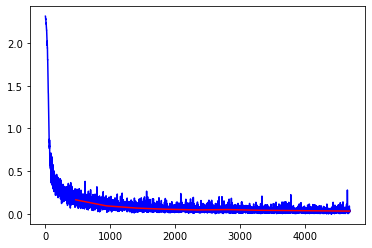

In [10]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.5)

train_losses = []
valid_losses = []
valid_x = []
num_epochs = 10
for epoch in range(1, num_epochs + 1):
    epoch_losses = train(80, model, device, train_loader, optimizer, epoch)
    train_losses.extend(epoch_losses)
    valid_loss = validate(model, device, valid_loader)
    valid_losses.append([valid_loss])
    valid_x.append(len(train_losses) - 1)

plt.gcf().clear()
plt.plot(train_losses, 'b-')
plt.plot(valid_x, valid_losses, 'r-')
plt.show()